<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/analysis/mastromatteo-05/Mastromatteo_5_PSD_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/analysis/mastromatteo-05/Mastromatteo_5_PSD_analysis.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# PSD Analysis

The analysis notebook relies on the ["Nuclear particle master"](https://docs.google.com/spreadsheets/d/1zgp8MplLXNAI1s7NAs7tCCVnv7N05AR4Q7x4hnE_PiA/edit?gid=0#gid=0) sheet to provide timestamps that allow us to separate the radiation data from experiments into several regions. In ideal experiments, we'll have:
- Set-up
- Calibration (30 min with source)
- Background 1 (12 hours)
- Experiment
- Background 2 (12 hours)

A PSD plot will be created for the calibration period in order to extract a `psp_threshold` that allows us to discriminate between gammas and neutrons. This threshold is then saved back to the master sheet.



## Running this notebook

Go ahead and change the `experiment_id` and `channel_number` below and then run the whole notebook.

You will be asked a couple of time to authenticate with your Google account, but after that all the analysis will happen automatically.

In [ ]:
experiment_id = 13
channel_number = 2

## Libraries

In [ ]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Interacting with sheets
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Authentication

We need to do a few authentication steps:
- Bring in the database credentials from Google drive so that we can pull data from the live database.
- Bring in the nuclear particle master sheet ID
-  Authenticate Colab to pull the nuclear particle master sheet using the Drive API.

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials.py", "psql_credentials.py")

# Copy sheet ID file from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/sheet_ids.py", "sheet_ids.py");

Mounted at /content/drive


In [ ]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Import sheet ID for the nuclear particle master sheet
from sheet_ids import NUCLEAR_PARTICLE_MASTER as sheet_id

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [ ]:

# Authenticate using Colab's built-in credentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Extracting experimental timestamps

We need to
- Open the master sheet
- Find the row corresponding with the experiment
- Extract the timestamp columns

Because the master sheet is organised in blocks that share an experiment ID (to avoid visual overload) we'll need to "fill in" the experiment ID for all rows once the sheet is brought into a pandas dataframe.



In [ ]:
# Fill experiment IDs based on the block organisation of the master sheet
def fill_experiment_id(df):
    experiment_id = None
    updated_ids = []

    for index, row in df.iterrows():
        if pd.notna(row['Experiment ID']) and row['Experiment ID'] != '':
            experiment_id = row['Experiment ID']
        updated_ids.append(experiment_id)

    df['Experiment ID'] = updated_ids
    return df

In [ ]:
sheet = gc.open_by_key(sheet_id).sheet1

# Read the sheet into a pandas DataFrame
df = pd.DataFrame(sheet.get_all_records())

# Fill the experiment IDs based on the block organisation of the master sheet
df = fill_experiment_id(df)

In [ ]:
# Find the rows where Experiment ID matches
rows = df[df['Experiment ID'] == experiment_id]

if len(rows) == 0:
  raise ValueError(f"No matser sheet entry for 'Experiment ID' = {experiment_id}")

# Exract digitizer for SQL table identification
digitizer = rows.iloc[0]["Digitizer"]

# Extract times
times = rows.iloc[[0]][['Setup', 'Calibration', 'Background 1', 'Experiment', 'Background 2', 'End']]
times = times.apply(pd.to_datetime)

# Extract the row corresponding to the specified channel number
row = rows[rows["Digitizer channel number"] == channel_number]

if len(row) == 0:
  raise ValueError(f"No matser sheet entry for 'Experiment ID' = {experiment_id}, 'Digitizer channel number' = {channel_number}")

# Display the extracted times
times.head()

,Setup,Calibration,Background 1,Experiment,Background 2,End
28,2025-08-01 17:30:00,2025-08-01 18:28:00,2025-08-01 18:34:00,2025-08-04 15:06:00,NaT,NaT


## Compiling PSD data from radiation events

We collect the time, energy and psp value of each radiation event and store it in a SQL database. In order to create a PSD plot and perform analysis, we need to work with 2D histogram. In other words, we need to count the number of events in given energy/psp buckets.

The database is optimised for performing these kind of aggregations over large volumes of data so we lean on its capabilities instead of attempting to bring all the data into python and then aggregating.


In [ ]:
def get_psd_data(start_time, end_time):
  query = f"""
  SELECT
      width_bucket(channels[1], 0, 1, 128) AS psp_bin,
      width_bucket(channels[2], 0, 4000, 512) AS energy_bin,
      COUNT(*) AS count
  FROM {digitizer}_ch{channel_number}
  WHERE time BETWEEN '{start_time}' AND '{end_time}'
  GROUP BY psp_bin, energy_bin
  ORDER BY psp_bin, energy_bin;
  """
  return pd.read_sql(query, engine, index_col=None)


def get_all_psd_data(times):
    psd_data = {}
    psd_periods = {}
    columns = times.columns  # Include all columns, including 'Setup'

    for i in range(len(columns) - 1):  # Stop before the last column
        start_time = times.iloc[0, i]
        if pd.notna(start_time):
            # Find the next non-empty time
            end_time = None
            for j in range(i + 1, len(columns)):
                if pd.notna(times.iloc[0, j]):
                    end_time = times.iloc[0, j]
                    break
            # Only proceed if a valid end_time was found
            if end_time is not None:
                data = get_psd_data(start_time, end_time)
                psd_data[columns[i]] = data
                psd_periods[columns[i]] = end_time - start_time

    return psd_data, psd_periods

We will now extract PSD data for all periods in our experiment.

In [ ]:
psd_data, psd_periods  = get_all_psd_data(times)

Sometimes an experiment will be ongoing so we won't have data for the different periods yet. We'll create a helper function to check this for us so that we don't run into errors later on in the notebook.

In [ ]:
# Checks to see if experimental data for a particular period exists
def data_exists(label):
    if label in psd_data:  # Check if dict key exists (false if there are no dates for this period in the master sheet)
        if len(psd_data[label]) > 0:  # Check if array is non-empty (false is there is no data for this period in the databse)
            return True
        else:
            return False
    else:
        return False

If we do not have an official calibration period, we'll use the next period (e.g. Background 1 or Experiment) for calculting the PSP threshold.

In [ ]:
if not data_exists("Calibration"):
  print("Calibration data does not exist, looking for other data to use in place of an official calibration period")
  if data_exists("Background 1"):
    psd_data["Calibration"] = psd_data["Background 1"]
    psd_periods["Calibration"] = psd_periods["Background 1"]
    print("Using Background 1 data for calibration")
  elif data_exists("Experiment"):
    psd_data["Calibration"] = psd_data["Experiment"]
    psd_periods["Calibration"] = psd_periods["Experiment"]
    print("Using Experiment data for calibration")
  elif data_exists("Setup"):
    psd_data["Calibration"] = psd_data["Setup"]
    psd_periods["Calibration"] = psd_periods["Setup"]
    print("Using Setup data for calibration")

## Visualising the PSD plots

In [ ]:
def plot_psd(data, period=None, title="PSD", psp_threshold=None, ax=None):
    # Initialise histogram
    hist = np.zeros((512, 128), dtype=int)

    if period is not None:
        days = period.days
        hours = period.components.hours
        days_str = f"{days} day" if days == 1 else f"{days} days" if days > 0 else ""
        hours_str = f"{hours} hour" if hours == 1 else f"{hours} hours"
        period_string = f"{days_str}, {hours_str}" if days > 0 else hours_str
        period_string = period_string.strip(", ")
    else:
        period_string = None

    # Accumulate counts
    for row in data.itertuples(index=False):
        psp_bin, energy_bin, count = row
        if 0 <= energy_bin < 512 and 0 <= psp_bin < 128:
            hist[energy_bin, psp_bin] += int(count)

    # Define bin edges
    energy_edges = np.linspace(0, 4000, 513)  # 512 bins → 513 edges
    psp_edges = np.linspace(0, 1, 129)        # 128 bins → 129 edges

    # Plot with pcolormesh and log colour scale
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)

    im = ax.pcolormesh(energy_edges, psp_edges, hist.T,
                      norm=mcolors.LogNorm(vmin=1, vmax=hist.max()),
                      cmap='viridis', shading='auto')
    ax.set_xlabel('Energy')
    ax.set_ylabel('PSP')
    if period_string is not None:
        ax.set_title(f"{title} ({period_string})")
    else:
        ax.set_title(title)

    # Draw horizontal red line at psp_threshold if provided
    if psp_threshold is not None:
        if 0 <= psp_threshold <= 1:  # Ensure threshold is within PSP range [0, 1]
            ax.axhline(y=psp_threshold, color='red', linestyle='-', label=f'PSP Threshold: {psp_threshold:.3f}')
            ax.legend()

    # Add colorbar
    plt.colorbar(im, ax=ax, label='Count (log scale)')

    if ax is None:
        plt.show()

We begin with the calibration period for which we have the largest number of events due to the presence of a source of radiation. This PSD plot is what we'll use to extract a simple psp threshold value that can be used to quickly discriminate between gammas (lower psp) and neutrons (higher psp).  

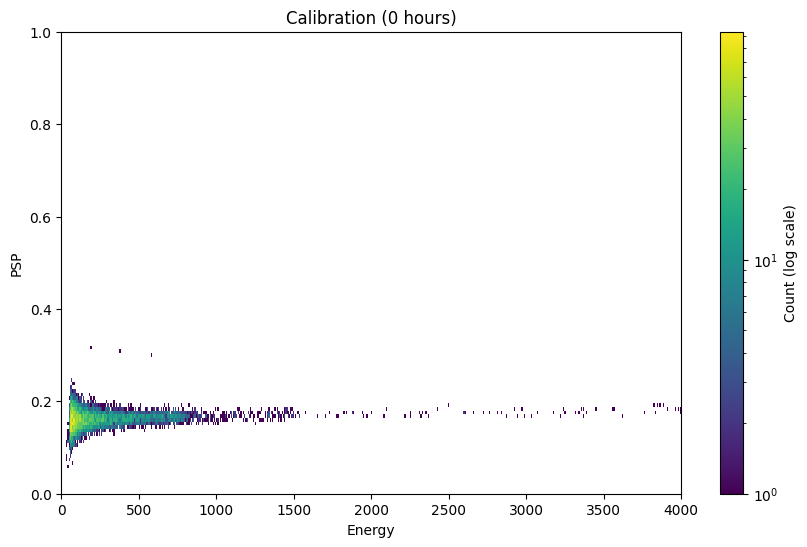

In [ ]:
if data_exists("Calibration"):
  plot_psd(psd_data["Calibration"], psd_periods["Calibration"], "Calibration")
else:
  print("‼️ Calibration data does not exist, cannot create PSD plot. ‼️")


## Calculating the PSP threshold

The most accurate way to discriminate between gammas and neutrons is to create a fiducial lines. For the purpose of eyeballing neutron/gamma counts during a live experiment, a simple threshold psp value can be a good enough.

In this notebook, we'll trial two methods
- midpoint method
- Guassaian drop method

For the midpoint method
- Choose an energy value
- Determine the psp locations of the gamma and neutron peaks
- Take the half way point between the two values.

For the Guassaian drop method
- Fit the signals with Guassians
- Find the psp value at which the gammas drop to some fraction of their peak, e.g. 0.1%

We'll attempt the midpoint first and then if that fails, then we'll fallback to the Guassaian drop method.

In [ ]:
def find_psp_midpoint(data, target_energy=500, prominence=10, energy_range=(0, 4000), psp_range=(0, 1), energy_bins=512, psp_bins=128):
    # Step 1: Map target_energy to the closest energy_bin
    bin_width = (energy_range[1] - energy_range[0]) / energy_bins  # 4000 / 512 = 7.8125
    closest_energy_bin = int(round(target_energy / bin_width))
    closest_energy_bin = max(1, min(closest_energy_bin, energy_bins))  # Clamp to [1, 512]
    print(f"Closest energy bin to {target_energy}: {closest_energy_bin}")

    # Step 2: Filter data for the closest energy_bin
    filtered_data = data[data['energy_bin'] == closest_energy_bin]
    if filtered_data.empty:
        raise ValueError(f"No data found for energy bin {closest_energy_bin} (energy ~{target_energy})")

    # Step 3: Prepare PSP distribution for peak detection
    psp_bin_width = (psp_range[1] - psp_range[0]) / psp_bins  # 1 / 128 = 0.0078125

    # Create a histogram-like array for the full PSP range
    hist = np.zeros(psp_bins)
    for idx, row in filtered_data.iterrows():
        psp_bin = row['psp_bin'] - 1  # Convert to 0-based index (since psp_bin is 1 to 128)
        count = row['count']
        if 0 <= psp_bin < psp_bins:
            hist[psp_bin] += count

    # Find peaks using scipy.signal.find_peaks
    peaks_indices, _ = find_peaks(hist, height=0, prominence=prominence)  # Adjust prominence as needed
    if len(peaks_indices) < 2:
        raise ValueError("Not enough significant peaks detected; adjust prominence or check data.")

    # Get the two highest peaks based on prominence
    peak_indices_sorted = sorted(peaks_indices, key=lambda x: hist[x], reverse=True)[:2]
    if len(peak_indices_sorted) < 2:
        raise ValueError("Not enough prominent peaks to determine midpoint.")

    # Convert peak indices to PSP values
    peak1_idx, peak2_idx = peak_indices_sorted[:2]
    peak1_value = (peak1_idx + 0.5) * psp_bin_width  # Bin center
    peak2_value = (peak2_idx + 0.5) * psp_bin_width  # Bin center
    peak1_value, peak2_value = sorted([peak1_value, peak2_value])  # Ensure peak1 < peak2
    print(f"Peak PSP values: {peak1_value:.6f}, {peak2_value:.6f}")

    # Step 4: Calculate midpoint in PSP units
    midpoint = (peak1_value + peak2_value) / 2
    print(f"Midpoint between PSP peaks: {midpoint:.6f}")

    # Step 5: Plot PSP distribution with peaks and midpoint
    plt.figure(figsize=(8, 5))
    psp_centers = np.arange(psp_bins) * psp_bin_width + psp_bin_width / 2  # Bin centers
    plt.bar(psp_centers, hist, width=psp_bin_width, alpha=0.7)
    plt.axvline(peak1_value, color='r', linestyle='--', label=f'Peak 1: {peak1_value:.3f}')
    plt.axvline(peak2_value, color='g', linestyle='--', label=f'Peak 2: {peak2_value:.3f}')
    plt.axvline(midpoint, color='b', label=f'Midpoint: {midpoint:.3f}')
    plt.xlabel('PSP')
    plt.ylabel('Count')
    plt.title(f'PSP Distribution at Energy ~{target_energy}')
    plt.legend()
    plt.show()

    return midpoint

In [ ]:
# --- Gaussian definitions ---
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (gaussian(x, amp1, mu1, sigma1) +
            gaussian(x, amp2, mu2, sigma2))

def find_psp_threshold_gaussian(data, target_energy=500,
                                     energy_range=(0, 4000), psp_range=(0, 1),
                                     energy_bins=512, psp_bins=128,
                                     plot=True, mean_tol=0.02, amp_ratio_tol=0.1,
                                     drop_fraction=0.001):
    """
    Fits Gaussian(s) to PSP distribution at a given energy and finds PSP threshold
    where the lower Gaussian drops to 0.1% of its peak.
    Falls back to single Gaussian if fitted Gaussians are too similar.
    """

    # Step 1: Map energy to closest bin
    bin_width_e = (energy_range[1] - energy_range[0]) / energy_bins
    closest_energy_bin = int(round(target_energy / bin_width_e))
    closest_energy_bin = max(1, min(closest_energy_bin, energy_bins))

    # Step 2: Filter data for that energy bin
    filtered = data[data['energy_bin'] == closest_energy_bin]
    if filtered.empty:
        raise ValueError(f"No data for bin {closest_energy_bin} (~{target_energy})")

    # Step 3: Build histogram
    psp_bin_width = (psp_range[1] - psp_range[0]) / psp_bins
    hist = np.zeros(psp_bins)
    for _, row in filtered.iterrows():
        idx = row['psp_bin'] - 1
        if 0 <= idx < psp_bins:
            hist[idx] += row['count']

    psp_centres = np.arange(psp_bins) * psp_bin_width + psp_bin_width / 2

    # Step 4: Try to detect peaks
    peaks, _ = find_peaks(hist, height=np.max(hist) * 0.05)
    use_double = len(peaks) >= 2

    if use_double:
        # Initial guess: amplitudes, means, sigmas
        p0 = [hist[peaks[0]], psp_centres[peaks[0]], 0.05,
              hist[peaks[1]], psp_centres[peaks[1]], 0.05]
        bounds = (0, [np.inf, 1, np.inf, np.inf, 1, np.inf])
        popt, _ = curve_fit(double_gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [(popt[0], popt[1], popt[2]), (popt[3], popt[4], popt[5])]

        # Check if we should fall back to single Gaussian
        mu_diff = abs(params[0][1] - params[1][1])
        amp_ratio = min(params[0][0], params[1][0]) / max(params[0][0], params[1][0])
        if mu_diff < mean_tol or amp_ratio < amp_ratio_tol:
            use_double = False

    if not use_double:
        # Fit single Gaussian
        p0 = [np.max(hist), psp_centres[np.argmax(hist)], 0.05]
        bounds = (0, [np.inf, 1, np.inf])
        popt, _ = curve_fit(gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [tuple(popt)]

    # Step 5: Select lower Gaussian (smallest mean)
    lower_gauss = min(params, key=lambda p: p[1])
    amp, mu, sigma = lower_gauss

    # Step 6: Compute PSP threshold at 1% of peak
    delta = np.sqrt(-2 * sigma**2 * np.log(drop_fraction))
    psp_threshold = mu + delta  # right-side cutoff

    # Step 7: Plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.bar(psp_centres, hist, width=psp_bin_width, alpha=0.6, label="Data")
        if use_double:
            plt.plot(psp_centres, double_gaussian(psp_centres, *popt), 'k-', label="Double Gaussian fit")
            for amp_i, mu_i, sigma_i in params:
                plt.plot(psp_centres, gaussian(psp_centres, amp_i, mu_i, sigma_i), '--', label=f"Gaussian μ={mu_i:.3f}")
        else:
            plt.plot(psp_centres, gaussian(psp_centres, *params[0]), 'k-', label="Single Gaussian fit")
        plt.axvline(psp_threshold, color='r', linestyle='--', label=f"Threshold={psp_threshold:.3f}")
        plt.xlabel('PSP')
        plt.ylabel('Count')
        plt.title(f'PSP Gaussian Fit at Energy ~{target_energy}')
        plt.legend()
        plt.show()

    return psp_threshold


For this tutorial, we'll experiment with different energies for determining a rough psp thresold value:
- Energy = 500 for the midpoint method
- Energy = 100 for the Gaussian drop method

Closest energy bin to 500: 64
find_psp_midpoint failed, attemping find_psp_threshold_gaussian


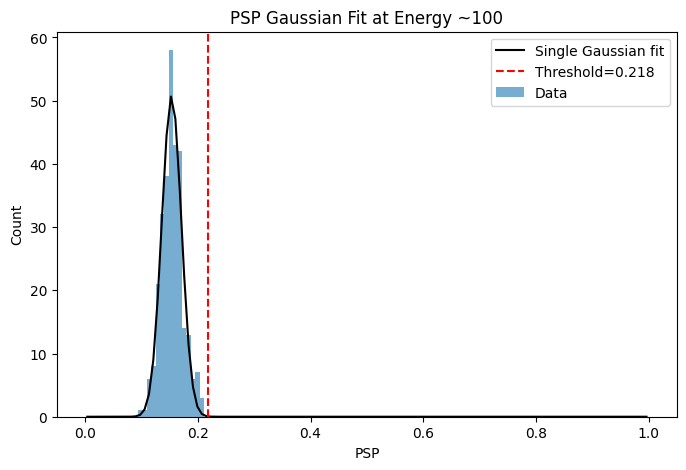

In [ ]:

if data_exists("Calibration"):
  try:
    psp_threshold = find_psp_midpoint(psd_data["Calibration"], target_energy = 500, prominence=5)
  except:
    print("find_psp_midpoint failed, attemping find_psp_threshold_gaussian")
    psp_threshold = find_psp_threshold_gaussian(psd_data["Calibration"], target_energy=100, drop_fraction=0.001)
else:
  psp_threshold = None
  print("‼️ Calibration data does not exist, cannot perform psp thresold analysis ‼️")


Now that we have our threshold, we can remake the PSD plots to see if there is anything obviously wrong with the analysis.

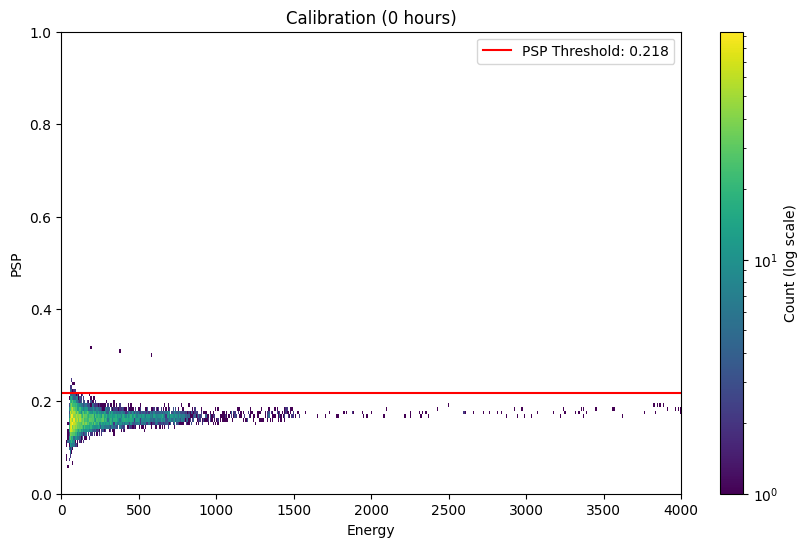

In [ ]:
if data_exists("Calibration"):
  plot_psd(psd_data["Calibration"], psd_periods["Calibration"], "Calibration", psp_threshold)
else:
  print("‼️ Calibration data does not exist, cannot create PSD plot ‼️")

It can also be instructive to create the PSD plots for the background periods - we would not expect significant changes between the two. Here, we just eyeball them, but performing a statistical analysis will be the next step.

Background 2 data does not exist, plotting just Background 1 data


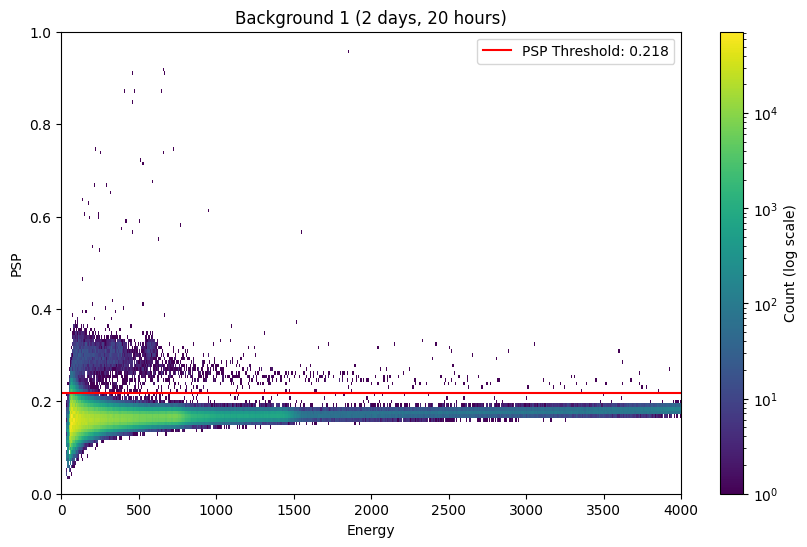

In [ ]:
if data_exists("Background 1") and data_exists("Background 2"):
  fig, axes = plt.subplots(1, 2, figsize=(14, 5), squeeze=False)
  axes = axes.flatten()  # Flatten for easy indexing
  plot_psd(psd_data["Background 1"], psd_periods["Background 1"], 'Background 1', psp_threshold, ax=axes[0])
  plot_psd(psd_data["Background 2"], psd_periods["Background 2"], 'Background 2', psp_threshold, ax=axes[1])
elif data_exists("Background 1"):
  print("Background 2 data does not exist, plotting just Background 1 data")
  plot_psd(psd_data["Background 1"], psd_periods["Background 1"], 'Background 1', psp_threshold)
elif data_exists("Background 2"):
  print("Background 1 data does not exist, plotting just Background 2 data")
  plot_psd(psd_data["Background 2"], psd_periods["Background 2"], 'Background 2', psp_threshold)
else:
  print("‼️ Background data does not exist, cannot create PSD plots ‼️")

And of course we can look at the experimental period.

In [ ]:
if data_exists("Experiment"):
  plot_psd(psd_data["Experiment"], psd_periods["Experiment"], psp_threshold=psp_threshold)
else:
  print("‼️ Exeperiment data does not exist, cannot create PSD plot ‼️")

‼️ Exeperiment data does not exist, cannot create PSD plot ‼️


Finally, we now update the master spreadsheet with the PSP threshold that will be used to gamma/neutron discrimination.

In [ ]:
if psp_threshold is not None and "Calibration" in psd_data:
  # Calculate the row number (adjusting for header row)

  row_num = row.index[0] + 2  # +2 because DataFrame index 0 maps to row 2 (header is row 1)
  # Get the column position

  col_position = df.columns.get_loc('psp threshold') + 1  # 1-based column number
  # Update the specific cell

  sheet.update_cell(row_num, col_position, psp_threshold)
  print("Google Sheet updated successfully.")
else:
  print("‼️ No psp threshold has been calculated. Nothing to upload to master sheet.")

Google Sheet updated successfully.
